In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import pickle

In [2]:
orders = pd.read_csv('data/orders.csv', sep=',')
products = pd.read_csv('data/products.csv', sep=',')
history = pd.read_csv('data/order_products__prior.csv', sep=',')

## Different vectorizations

The very first idea that comes to our mind, which was also used in the second homework, is to represent a user with the set of products he bought.

In [3]:
orders_small = orders[["order_id","user_id"]].sort_values(by='order_id')#.head(105629)
history_small = history[["order_id","product_id"]].sort_values(by='order_id')#.head(1000000)

The next 3 boxes are useless, but might be used at some point ater if we follow a slightly different approach.

In [4]:
consumptions = pd.merge(history_small, orders_small, on="order_id")[['user_id','product_id']]
#users_per_product = consumptions.groupby('product_id').agg(set)

In [ ]:
'''
def add_similarity(user1, user2, sim, amount):
    if user1 in  sim[user2] : # user1 and user2 are already neighbours
        sim[user1][user2]+=amount
        sim[user2][user1]+=amount
    else :     
        sim[user1][user2]=amount
        sim[user2][user1]=amount
        
def light_similarity_matrix(prod_set, nb_users):
    sim = [{} for x in range(nb_users)]
    n=0
    # sim[n] is the dictionary such that dict[m] = nb of similar products bought by m and n. If this is 0, dict[m] is not defined
    for set_users in prod_set.user_id :
        # For each pair of users
        for user1 in set_users :
            for user2 in set_users :
                if user1<user2 :
                    n+=2
                    add_similarity(user1, user2, sim, 1)
    print(n)
    return sim

sim = light_similarity_matrix(users_per_product.head(100), 206209)
'''

In [5]:
consumptions_with_details = pd.merge(consumptions,products, on="product_id")[['user_id','product_id','aisle_id','department_id']]
consumptions_with_details.head()

,user_id,product_id,aisle_id,department_id
0,202279,33120.0,86,16
1,153404,33120.0,86,16
2,23750,33120.0,86,16
3,58707,33120.0,86,16
4,166654,33120.0,86,16


In [8]:
max_user_id = max(consumptions_with_details["user_id"])
print('The greatest user id is '+str(max_user_id)+".")

The greatest user id is 206209.


In [7]:
# We split the dataframe into 2 smaller ones, because the kernel crashes at the next step if we keep the big one
consumptions_1 = consumptions_with_details[consumptions_with_details.user_id<max_user_id//2]
consumptions_2 = consumptions_with_details[consumptions_with_details.user_id>=max_user_id//2]
assert(len(consumptions_with_details)==len(consumptions_1)+len(consumptions_2))

### A - Set of aisles with total number products bought in the aisle

In [9]:
max_aisle_id = max(consumptions_with_details.aisle_id)
print("The greatest aisle id is "+str(max_aisle_id)+".")

The greatest aisle id is 134.


In [10]:
consumption_aisle_1 = consumptions_1[["user_id","product_id", "aisle_id"]].groupby(['user_id','aisle_id']).agg({'product_id': "count"})
consumption_aisle_2 = consumptions_2[["user_id","product_id", "aisle_id"]].groupby(['user_id','aisle_id']).agg({'product_id': "count"})
consumption_aisle_1.head()

product_id
user_id aisle_id            
1       21                 3
        23                 3
        24                 4
        77                 3
        88                 1

In [12]:
def init_matrix_aisle():
    np1 = []
    for w in range(max_user_id+1):
        np1.append([0 for x in range(max_aisle_id+1)])
    return np1

def to_tab_vect(consumption,mat=init_matrix_aisle()):
    '''Returns the matrix M such that M[user][aisle] = number of distinct products bought by user in aisle'''
    n=0
    n_pairs = len(consumption)
    for (user, aisle) in consumption.index :
        n+=1
        mat[user][aisle] = consumption.product_id[(user, aisle)]
        if n%250000==0 : print(str(round(100*(n/n_pairs),1))+ "% processed")
    print('Done !')
    return mat

In [13]:
user_matrix = to_tab_vect(consumption_aisle_1)
user_matrix = to_tab_vect(consumption_aisle_2, user_matrix)

6.5% processed
13.1% processed
19.6% processed
26.1% processed
32.6% processed
39.2% processed
45.7% processed
52.2% processed
58.7% processed
65.3% processed
71.8% processed
78.3% processed
84.8% processed
91.4% processed
97.9% processed
Done !
6.6% processed
13.2% processed
19.7% processed
26.3% processed
32.9% processed
39.5% processed
46.0% processed
52.6% processed
59.2% processed
65.8% processed
72.4% processed
78.9% processed
85.5% processed
92.1% processed
98.7% processed
Done !


### B - Clustering and evaluation of the best number of clusters

In [6]:
def score(k, user_mat, proportion=1):
    try : 
        sk = open("kmeans_"+str(k),"rb")            
        print("Lucky you, kmeans have already been computed !")
        kmeans = pickle.load(sk)
        sk.close()
    except FileNotFoundError :
        print("Computing kmeans...")
        kmeans = KMeans(n_clusters=k, random_state=0).fit(user_mat)
        sk = open("kmeans_"+str(k),"wb")
        pickle.dump(kmeans, sk)
        sk.close()
        print("K-means saved in file kmeans_"+str(k))
    labels = kmeans.labels_
    print("Calculating the silhouette score (this may take a while)...")
    user_mat_light = []
    labels_light = []
    if proportion==1 :
        return silhouette_score(user_mat, labels)
    else :
        for i in range(len(user_mat)):
            if rd.random()<=proportion :
                user_mat_light.append(user_mat[i])
                labels_light.append(labels[i])
        return silhouette_score(user_mat_light, labels_light)

In [25]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import random as rd
import pickle
import matplotlib.pyplot as plt


def compute_scores(user_mat="", n_max=50, proportion=0.2,filename="scores"):
    '''Comutes as many silhouette scores as possible and registers them in file scores'''
    if user_mat=="":
        print("Loading user matrix...")
        s=open("users_matrix","rb")
        user_mat=pickle.load(s)
        s.close()
    
    for k in range(2,n_max) :
        print("\n k="+str(k))
        s=open(filename,"rb")
        scores = pickle.load(s)
        print(scores)
        s.close()
        if k in scores and scores[k]["proportion"]>=proportion+0.2:
            print('Score already calculated for k=',k,"(that is ",scores[k],")")
        else :
            print('Computing the score for K-means with '+str(k)+" clusters...")
            s=open(filename,"rb")
            scores = pickle.load(s)
            s.close()
            sc =score(k, user_mat, proportion)
            if k in scores : 
                # Make a weighted average with previously obtained scores, if tey exist
                prop = proportion + scores[k]["proportion"]   
                sc = (sc*proportion + scores[k]["score"]*scores[k]["proportion"])/prop
            else : prop = proportion
            scores[k] = {"score":sc, "proportion":prop}
            print("Score calculated for k=",k," :",scores[k])
            s=open(filename,"wb")
            pickle.dump(scores,s)
            s.close()
            print('Scores saved in file "'+filename+'" under pickle format')               

In [ ]:
def print_scores() :
    s=open("scores",'rb')
    scores = pickle.load(s)
    s.close()
    X,Y, Z=[],[],[]
    for k in scores :
        X.append(k)
        Y.append(scores[k]["score"])
        Z.append(scores[k]["proportion"])
    plt.plot(X,Y,"r")
    plt.plot(X,Z,"b")

In [26]:
compute_scores("",50,0.1)

Loading user matrix...


KeyboardInterrupt: 

{'score': 0.6592836313223515, 'proportion': 0.05}
{'score': 0.5087411803582508, 'proportion': 0.05}
{'score': 0.40091164490961056, 'proportion': 0.05}
{'score': 0.3879837713089932, 'proportion': 0.05}
{'score': 0.38217006592530667, 'proportion': 0.05}
{'score': 0.3338921254578145, 'proportion': 0.05}
{'score': 0.30346340599248917, 'proportion': 0.05}
{'score': 0.2999561464484978, 'proportion': 0.05}
{'score': 0.2723134633466197, 'proportion': 0.05}


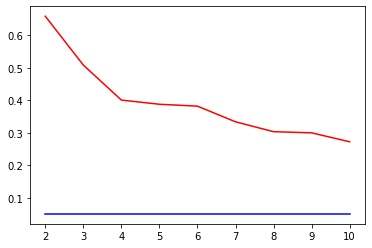

In [24]:
print_scores()